In [27]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import random

In [ ]:
data = pd.read_csv('../Datasets/poi_dataset_eng_pre.csv')

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tier             1492 non-null   int64  
 1   locationLon      1492 non-null   float64
 2   locationLat      1492 non-null   float64
 3   xps              1492 non-null   int64  
 4   main_image_path  1492 non-null   object 
 5   eng_cat          1492 non-null   object 
 6   tags_count       1492 non-null   int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 81.7+ KB


#### Semilla 




In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)


#### Conversión del target a formato numérico

1. **Casteo de `eng_cat` a `category`**  
   Garantiza un dtype compacto y explícito antes de mapear valores.

2. **Mapeo ordinal**  
   | Clase | Índice |
   |-------|--------|
   | Low   | 0 |
   | Mid   | 1 |
   | High  | 2 |

   El orden refleja la progresión natural de engagement (Low < Mid < High).  
   El vector resultante **`target`** se almacena como `int64`, listo para `nn.CrossEntropyLoss`.



In [5]:
data['eng_cat'] = data['eng_cat'].astype('category') 

In [6]:
# Manteniendo el orden Low < Mid < High
ENG_MAP = {'Low': 0, 'Mid': 1, 'High': 2}
target = data['eng_cat'].map(ENG_MAP).to_numpy('int64')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   tier             1492 non-null   int64   
 1   locationLon      1492 non-null   float64 
 2   locationLat      1492 non-null   float64 
 3   xps              1492 non-null   int64   
 4   main_image_path  1492 non-null   object  
 5   eng_cat          1492 non-null   category
 6   tags_count       1492 non-null   int64   
dtypes: category(1), float64(2), int64(3), object(1)
memory usage: 71.7+ KB


### Carga de representaciones textuales

A continuación incorporamos al notebook las dos matrices numéricas generadas en el pre-procesado:

| Archivo | Contenido | Dimensión |
|---------|-----------|-----------|
| **`cat_seqs.npy`** | Secuencias indexadas de *categories* (con padding) | **(1492 × MAX_LEN)** |
| **`desc_vectors.npy`** | Vectores LSA (TF-IDF + SVD) de *shortDescription* | **(1492 × 100)** |



In [8]:
# cargamos categorías y descripciones
categories = np.load('cat_seqs.npy', allow_pickle=True)
descriptions = np.load('desc_vectors.npy', allow_pickle=True)


In [9]:
print('Categories ->', type(categories), len(categories), 'ej. long:', len(categories[0]))
print('Descriptions ->', descriptions.shape, descriptions.dtype)


Categories -> <class 'numpy.ndarray'> 1492 ej. long: 4
Descriptions -> (1492, 100) float32


### Pipeline de *data augmentation* para las imágenes

In [10]:
# definimos el transform para las imágenes
transform = transforms.Compose([
    transforms.Resize(256, antialias=True),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

### Transformación `process_features`

**Objetivo**  
Centralizar la conversión de cualquier `np.ndarray` a `torch.Tensor`, garantizando el tipo de dato adecuado para cada caso ( `float32` en *features*; `long` en etiquetas).

**Parámetros**  
| Nombre  | Tipo | Descripción |
|---------|------|-------------|
| `arr`   | *np.ndarray* | Array de entrada (descripciones, metadata numérica, labels…). |
| `dtype` | *torch.dtype* (defecto `torch.float32`) | Tipo destino del tensor. Usar `torch.long` para vectores de clase. |

**Retorno**  
`torch.Tensor` contiguo en memoria y con el `dtype` solicitado, listo para ser pasado al modelo o concatenado con otras modalidades.

**Ventajas clave**  
-  **Uniformidad** Evita la dispersión de casteos a lo largo del código y previene que NumPy cuelen `float64`.  
-  **Flexibilidad** Un mismo helper sirve para *features* y etiquetas; basta con cambiar `dtype`.  
-  **Compatibilidad PyTorch** Devuelve directamente tensores válidos para `DataLoader`/GPU, sin pasos extra.  

**Patrón de uso**  
1. Features numéricas o embeddings → `dtype=torch.float32`.  
2. Etiquetas (classes) → `dtype=torch.long`.  
3. Llamar a la función dentro del `__getitem__()` del `Dataset` permite mantener limpio y legible el pipeline.


In [11]:
def process_features(arr, dtype=torch.float32):
    
    arr = np.asarray(arr)  # garantiza ndarray
    if dtype == torch.float32:
        arr = arr.astype(np.float32, copy=False)
    elif dtype == torch.long:
        arr = arr.astype(np.int64,  copy=False)

    return torch.from_numpy(arr).to(dtype).contiguous()

### `POIDataset` – Dataset multimodal personalizado

| Método | Propósito | Detalles clave |
|--------|-----------|----------------|
| `__init__(self, target, image_path, features_df, features_ext1, features_ext2, transform)` | Inicializa y valida todas las modalidades. | * **Chequeo de coherencia** (`assert`): verifica que todos los arrays tengan la misma longitud **N**.<br>* **Conversión a tensores** mediante `process_features`:<br>  · `target` → `torch.long` (etiquetas).<br>  · `features_df` → `torch.float32` (metadatos numéricos).<br>  · `features_ext1` → `torch.long` (secuencias de tokens).<br>  · `features_ext2` → `torch.float32` (embeddings densos). |
| `__len__(self)` | Devuelve `N`. | Usa la longitud de `self.target`. |
| `__getitem__(self, idx)` | Devuelve un ejemplo multimodal. | * Lee la ruta `self.image_path[idx]` con PIL y aplica `transform` si existe.<br>* Retorna la tupla:<br>`(target, image_tensor, features_df, features_ext1, features_ext2)`. |

**Ventajas de este diseño**

1. **Multimodalidad clara** Cada modalidad se devuelve en su tensor correspondiente, con el dtype adecuado.  
2. **Extensible** Añadir otra fuente (audio, texto adicional…) implicaría un nuevo argumento y un campo más en la tupla.  
3. **Compatibilidad DataLoader** Al retornar solo tensores, PyTorch los agrupa en lotes sin pasos extra (collate personalizado si se quiere padding adicional).





In [12]:
from PIL import Image
class POIDataset(Dataset):
    def __init__(self, target, image_path, features_df ,features_ext1,features_ext2, transfrom=None):
        n = len(target)
        assert all(len(x) == n for x in [image_path, features_df, features_ext1, features_ext2]), \
        "Todos los arrays deben tener la misma longitud"
        
        self.target = process_features(target,dtype=torch.long)
        self.image_path = image_path
        self.features = process_features(features_df)
        self.features_ext1 = process_features(features_ext1, dtype=torch.long)
        self.features_ext2 = process_features(features_ext2)
        self.transform = transfrom
        

    def __len__(self):
        return len(self.target)
        

    def __getitem__(self, idx):
        target = self.target[idx]
        features = self.features[idx]
        features_ext1 = self.features_ext1[idx]
        features_ext2 = self.features_ext2[idx]
        im = Image.open(self.image_path[idx]).convert("RGB")
        if self.transform:
            im = self.transform(im)

        return target, im, features, features_ext1, features_ext2
        

### Creación del `POIDataset`

In [13]:
dataset = POIDataset(target=target, image_path=data.main_image_path.values, features_df=data.drop(columns=['eng_cat', 'main_image_path']).values,features_ext1=categories,features_ext2=descriptions, transfrom=transform)


#### Inspección rápida de un ejemplo del `POIDataset`



In [14]:
lbl = dataset[0][0]
print(lbl, lbl.shape, lbl.dtype, type(lbl))


tensor(1) torch.Size([]) torch.int64 <class 'torch.Tensor'>


In [15]:
from collections import Counter

cls_counts = Counter(dataset[i][0].item()   
                     for i in range(len(dataset)))
print("Conteo por clase:", cls_counts)



Conteo por clase: Counter({2: 498, 1: 497, 0: 497})


In [ ]:
y, img, x_df, x_cat, x_des = dataset[0]

print("Etiqueta           :", y, y.dtype)
print("Imagen             :", img.shape, img.dtype, img.min().item(), img.max().item())
print("Numéricas (x_df)   :", x_df.shape, x_df.dtype)
print("Categorías (x_cat) :", x_cat.shape, x_cat.dtype, "PAD_IDX =", (x_cat==0).sum().item())
print("Descripción (x_des):", x_des.shape, x_des.dtype)


Etiqueta           : tensor(1) torch.int64
Imagen             : torch.Size([3, 224, 224]) torch.float32 -2.1179039478302 -0.27067530155181885
Numéricas (x_df)   : torch.Size([5]) torch.float32
Categorías (x_cat) : torch.Size([4]) torch.int64 PAD_IDX = 0
Descripción (x_des): torch.Size([100]) torch.float32


#### Extracción de etiquetas e índices

* **`labels = dataset.target.numpy()`**  
  Convierte el tensor de etiquetas `LongTensor (N,)` a un `np.ndarray` plano, necesario para operaciones de *split* o muestreo con utilidades de NumPy / scikit-learn.

* **`idx_all = np.arange(len(labels))`**  
  Crea el vector `0 … N-1` con los índices de todos los ejemplos; se utilizará para generar las particiones `train / val` de forma reproducible (estratificada o aleatoria).


In [17]:
labels = dataset.target.numpy()           # (N,)
idx_all = np.arange(len(labels))

#### División estratificada en **train / val / test**

1. **Train (70 %)**  
   *Separa* el 70 % de los índices como conjunto de entrenamiento, preservando la proporción de clases mediante **`stratify=labels`**.

2. **Val (15 %)**  
   Del 30 % restante, toma la mitad (15 % del total) para validación, estratificando de nuevo con los labels correspondientes.

3. **Test (15 %)**  
   La otra mitad del bloque temporal constituye el conjunto de prueba, también estratificado.

| Conjunto | Nº de ejemplos | Porcentaje |
|----------|---------------|------------|
| Train    | **1 044** | 70 % |
| Val      | **224**   | 15 % |
| Test     | **224**   | 15 % |

*El uso de `SEED` garantiza que la misma partición pueda reproducirse en futuras ejecuciones.*


In [18]:
from sklearn.model_selection import train_test_split


idx_train, idx_temp = train_test_split(
    idx_all,
    test_size=0.30,
    stratify=labels,
    random_state = SEED
)
 
idx_val, idx_test = train_test_split(
    idx_temp,
    test_size=0.50,                 
    stratify=labels[idx_temp],
    random_state = SEED
)

print("Train :", len(idx_train), "Val :", len(idx_val), "Test :", len(idx_test))


Train : 1044 Val : 224 Test : 224


In [19]:
from collections import Counter
def cls_count(idxs):
    return Counter(labels[idxs])

print("Train cls:", cls_count(idx_train))
print("Val   cls:", cls_count(idx_val))
print("Test  cls:", cls_count(idx_test))


Train cls: Counter({np.int64(1): 348, np.int64(2): 348, np.int64(0): 348})
Val   cls: Counter({np.int64(1): 75, np.int64(2): 75, np.int64(0): 74})
Test  cls: Counter({np.int64(2): 75, np.int64(0): 75, np.int64(1): 74})


### Preparación de *datasets* y *dataloaders*

#### 1. Transformaciones de evaluación (`eval_tfms`)
* **Resize(256)** → escalado determinista y antialias.  
* **CenterCrop(224)** → recorte centrado; evita randomness en validación / test.  
* **ToTensor → Normalize** con estadísticas ImageNet (compatibilidad ResNet).

> Se crea `dataset_eval` como **copia superficial** de `dataset` y se le asigna `eval_tfms`, de modo que:
> * `dataset` (train) mantiene el pipeline de *data-augmentation*.
> * `dataset_eval` (val / test) utiliza transformaciones deterministas.


In [20]:
import copy, torch
from torchvision import transforms

eval_tfms = transforms.Compose([
    transforms.Resize(256, antialias=True),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

dataset_eval = copy.copy(dataset)       # copia superficial
dataset_eval.transform = eval_tfms


In [21]:
from torch.utils.data import Subset, DataLoader

train_ds = Subset(dataset,      idx_train)   # con augmentación
val_ds   = Subset(dataset_eval, idx_val)     # sin aug.
test_ds  = Subset(dataset_eval, idx_test)    # sin aug.

batch = 64
train_loader = DataLoader(train_ds, batch_size=batch, shuffle=True,
                          num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch, shuffle=False,
                          num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch, shuffle=False,
                          num_workers=0, pin_memory=True)


In [22]:
print(train_ds.dataset.transform)  # -> train_tfms  (con augment)
print(val_ds.dataset.transform)    # -> eval_tfms   (sin augment)
print(test_ds.dataset.transform)   # -> eval_tfms   (sin augment)


Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    RandomCrop(size=(224, 224), padding=None)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=(0.7, 1.3), hue=(-0.1, 0.1))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [23]:
import torch
import torch.nn as nn
import torchvision.models as models

class HybridPOI(nn.Module):
    """
    Imagen (3×224×224)   → ResNet-18*                       → 512-d
    Numéricas (5)        → MLP + BatchNorm + Dropout(0.5)   → 64-d
    Categorías (L)       → Embedding(16) + mean-pool        → 16-d
    Descripción (100)    → Linear                           → 128-d
    ----------------------------------------------------------------
    Concatenación (720-d) → LayerNorm → Head FC → 3 clases
    *Primeros 2 stages congelados + Dropout2d(0.2) interno
    """
    def __init__(self, *,
                 n_num=5,
                 desc_dim=100,
                 n_cats=len(set(categories.flatten())) + 1,   # vocab size (+pad)
                 cat_emb_dim=32,
                 n_classes=3,
                 pad_idx=0):
        super().__init__()

        # ------------ 1. Imagen (ResNet-18 con reducción de canales) -----
        res = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # a) hasta layer4 excluida  (salida 512 canales, 7×7)
        cnn_backbone = list(res.children())[:-2]

        # b) proyección 1×1 512→256  + BN + ReLU
        reduction = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        # c) Dropout2d + avg-pool
        cnn_backbone += [reduction, nn.Dropout2d(0.21457971687872748), res.avgpool]

        self.cnn  = nn.Sequential(*cnn_backbone)   # salida (B,256,1,1)
        cnn_dim   = 256                            # <-- cambia para la fusión

        # d) congelamos conv1, bn1, relu, maxpool, layer1 y layer2 (igual)
        for layer in list(self.cnn)[:7]:
            for p in layer.parameters():
                p.requires_grad = False


        # ------------ 2. Numéricas --------------------------
        self.num_branch = nn.Sequential(
            nn.LayerNorm(n_num),        # alternativa a BatchNorm
            nn.Linear(n_num, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
    
        )
        num_dim = 64

        # ------------ 3. Categorías -------------------------
        self.cat_emb  = nn.Embedding(n_cats, cat_emb_dim, padding_idx=pad_idx)
        self.emb_dp   = nn.Dropout(0.3)
        self.cat_proj = nn.Sequential(
            nn.Linear(cat_emb_dim, cat_emb_dim),
            nn.ReLU()
        )
        cat_dim = cat_emb_dim                               # 32

        # ------------ 4. Descripción ------------------------
        self.desc_branch = nn.Sequential(
            nn.Linear(desc_dim, 128),
            nn.ReLU()
        )
        desc_out = 128

        # ------------ 5. Fusión + Head ----------------------
        fused_dim = cnn_dim + num_dim + cat_dim + desc_out   # 512+64+16+128 = 720
        self.norm = nn.LayerNorm(fused_dim)

        self.head = nn.Sequential(
            nn.Linear(fused_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.40557914141875473),
            nn.Linear(128, n_classes)
        )

    def forward(self, img, x_num, x_cat, x_desc):
        # 1) imagen → conv
        x_img = self.cnn(img).squeeze(-1).squeeze(-1)        # (B,512)

        # 2) numéricas
        x_num = self.num_branch(x_num)                       # (B,64)

        # 3) categorías → embedding → mean-pool (ignora pads)
        emb = self.cat_emb(x_cat)            # (B,L,D)
        emb = self.emb_dp(emb)
        mask = (x_cat != self.cat_emb.padding_idx).unsqueeze(-1)
        x_cat = (emb * mask).sum(1) / mask.sum(1).clamp(min=1)   # mean-pool
        x_cat = self.cat_proj(x_cat)  # (B,16)

        # 4) descripción
        x_desc = self.desc_branch(x_desc)                    # (B,128)

        # 5) fusión + normalización + clasificación
        x = torch.cat([x_img, x_num, x_cat, x_desc], dim=1)  # (B,720)
        x = self.norm(x)
        return self.head(x)


##  `HybridPOI` – Arquitectura multimodal


> **Detalles clave**
> * ResNet-18 con pesos ImageNet; etapas conv1-layer2 congeladas.  
> * Reducción de canales (512→256) para aligerar la rama de imagen.  
> * Mean-pool sobre embeddings de categorías, ignorando tokens `<pad>`.  
> * `LayerNorm` antes del *head* estabiliza la fusión multimodal.  
> * Total parámetros entrenables ≈ 8 M (congelando primeros bloques).  
> * Dropout alto (0.64) en la cabeza para combatir sobre-ajuste.



In [24]:
# ---------------------------------- CONFIG MEJORADA ---------------------------------- #
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = HybridPOI(
    n_num    = 5,
    desc_dim = descriptions.shape[1],       # 100
    n_cats   = int(categories.max()) + 1,
    pad_idx  = 0
).to(device)

# ---------- Pesos por clase ---------------------------------------------------------- #
cls_counts  = np.bincount(dataset.target.numpy())
class_wts   = (cls_counts.sum() / (3 * cls_counts)).clip(max=2).astype(np.float32)
criterion   = nn.CrossEntropyLoss(
    weight=torch.tensor(class_wts, device=device),
    label_smoothing=0.1
)

# ---------- Optimizer con LR diferenciado ------------------------------------------- #
base_lr      = 0.0004551282223836388
weight_decay = 0.0006073715139164453

cnn_params, new_params = [], []
for n, p in model.named_parameters():
    if p.requires_grad:
        (cnn_params if n.startswith("cnn") else new_params).append(p)

optimizer = torch.optim.AdamW(
    [
        {"params": cnn_params, "lr": base_lr * 0.01},
        {"params": new_params, "lr": base_lr}
    ],
    weight_decay=weight_decay
)

# ---------- Scheduler (con min_lr) --------------------------------------------------- #
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=2, factor=0.5, min_lr=1e-6
)

# ---------- AMP ---------------------------------------------------------------------- #
scaler = torch.cuda.amp.GradScaler(enabled=device.type == "cuda")


C:\Users\Nauzet\AppData\Local\Temp\ipykernel_23164\2219982711.py:42: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=device.type == "cuda")


C:\Users\Nauzet\AppData\Local\Temp\ipykernel_23164\580722544.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


Ep 01 | train 1.0580/46.07% | val 0.9266/62.95% | LR 4.55e-04
Ep 02 | train 0.9202/63.03% | val 0.8026/73.66% | LR 4.55e-04
Ep 03 | train 0.8039/71.46% | val 0.7380/75.45% | LR 4.55e-04
Ep 04 | train 0.7214/76.63% | val 0.6630/81.70% | LR 4.55e-04
Ep 05 | train 0.6515/80.84% | val 0.6375/82.59% | LR 4.55e-04
Ep 06 | train 0.6357/82.28% | val 0.6183/83.48% | LR 4.55e-04
Ep 07 | train 0.6050/84.10% | val 0.6601/83.48% | LR 4.55e-04
Ep 08 | train 0.6163/81.13% | val 0.5959/83.93% | LR 4.55e-04
Ep 09 | train 0.6066/84.39% | val 0.6129/83.48% | LR 4.55e-04
Ep 10 | train 0.5843/85.06% | val 0.6004/83.48% | LR 4.55e-04
Ep 11 | train 0.6056/83.91% | val 0.6107/83.04% | LR 2.28e-04
Ep 12 | train 0.5718/84.96% | val 0.5711/85.27% | LR 2.28e-04
Ep 13 | train 0.5670/85.15% | val 0.5941/84.38% | LR 2.28e-04
Ep 14 | train 0.5652/84.77% | val 0.5950/84.38% | LR 2.28e-04
Ep 15 | train 0.5694/85.34% | val 0.6018/84.38% | LR 1.14e-04
Ep 16 | train 0.5566/85.92% | val 0.6073/83.93% | LR 1.14e-04
⏹️  Earl

C:\Users\Nauzet\AppData\Local\Temp\ipykernel_23164\580722544.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=device.type == "cuda"):


              precision    recall  f1-score   support

           0       1.00      0.95      0.97        75
           1       0.86      0.69      0.77        74
           2       0.74      0.93      0.83        75

    accuracy                           0.86       224
   macro avg       0.87      0.86      0.86       224
weighted avg       0.87      0.86      0.86       224



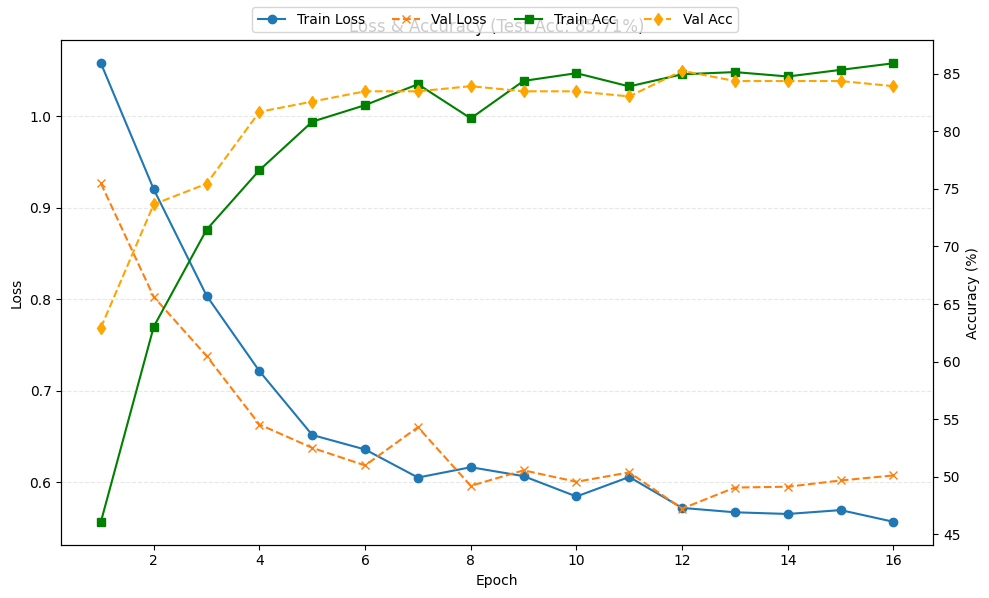

In [ ]:
from sklearn.metrics import classification_report


def run_epoch(loader, train=True):
    model.train() if train else model.eval()
    running_loss, correct, total = 0.0, 0, 0

    for y, img, x_df, x_cat, x_desc in loader:
        img, x_df, x_cat, x_desc, y = \
            img.to(device), x_df.to(device), x_cat.to(device), x_desc.to(device), y.to(device)

        if train:
            optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=device.type == "cuda"):
            out  = model(img, x_df, x_cat, x_desc)
            loss = criterion(out, y)

        if train:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        running_loss += loss.item() * y.size(0)
        correct      += (out.argmax(1) == y).sum().item()
        total        += y.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total          # proporción (0-1)
    return epoch_loss, epoch_acc
# ------------------------------------------------------------------



n_epochs   = 50
patience   = 4
best_val   = float("inf")
wait       = 0
history    = {"tr_loss":[], "val_loss":[], "tr_acc":[], "val_acc":[]}

for epoch in range(1, n_epochs + 1):
    tr_loss, tr_ac = run_epoch(train_loader, train=True)
    vl_loss, vl_ac = run_epoch(val_loader,   train=False)
    scheduler.step(vl_loss)

    history["tr_loss"].append(tr_loss); history["tr_acc"].append(tr_ac*100)
    history["val_loss"].append(vl_loss); history["val_acc"].append(vl_ac*100)

    lr_now = optimizer.param_groups[1]["lr"]
    print(f"Ep {epoch:02d} | "
          f"train {tr_loss:.4f}/{tr_ac*100:.2f}% | "
          f"val {vl_loss:.4f}/{vl_ac*100:.2f}% | "
          f"LR {lr_now:.2e}")

    # ----- early stopping -----
    if vl_loss < best_val - 1e-3:
        best_val, wait = vl_loss, 0
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
    else:
        wait += 1
        if wait == patience:
            print("⏹️  Early stopping triggered")
            break

model.load_state_dict(best_state)
model.to(device).eval()

y_true, y_pred = [], []
with torch.no_grad(), torch.cuda.amp.autocast(enabled=device.type == "cuda"):
    for y, img, x_df, x_cat, x_desc in test_loader:
        img, x_df, x_cat, x_desc = \
            img.to(device), x_df.to(device), x_cat.to(device), x_desc.to(device)
        out = model(img, x_df, x_cat, x_desc)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(out.argmax(1).cpu().numpy())

y_true = np.array(y_true); y_pred = np.array(y_pred)
print(classification_report(y_true, y_pred, digits=2))


epochs = range(1, len(history["tr_loss"]) + 1)
fig, ax1 = plt.subplots(figsize=(10,6))

ax1.plot(epochs, history["tr_loss"], "o-", label="Train Loss")
ax1.plot(epochs, history["val_loss"], "x--", label="Val Loss")
ax1.set_xlabel("Epoch"); ax1.set_ylabel("Loss"); ax1.grid(True, axis="y", linestyle="--", alpha=0.3)

ax2 = ax1.twinx()
ax2.plot(epochs, history["tr_acc"], "s-", label="Train Acc", color="green")
ax2.plot(epochs, history["val_acc"], "d--", label="Val Acc",   color="orange")
ax2.set_ylabel("Accuracy (%)")

handles, labels_ = [], []
for ax in (ax1, ax2):
    h, l = ax.get_legend_handles_labels()
    handles += h; labels_ += l
fig.legend(handles, labels_, loc="upper center", ncol=4)

test_accuracy = (y_pred == y_true).mean() * 100
plt.title(f"Loss & Accuracy (Test Acc: {test_accuracy:.2f}%)")
plt.tight_layout(); plt.show()




In [26]:
test_loss, test_acc = run_epoch(test_loader, train=False)
print(f"🔍  Test  loss {test_loss:.4f}  |  acc {test_acc:.3f}")


C:\Users\Nauzet\AppData\Local\Temp\ipykernel_23164\580722544.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=device.type == "cuda"):


🔍  Test  loss 0.5806  |  acc 0.857


In [ ]:
# Optuna – configurador para afinar el nuevo HybridPOI


import optuna, copy, torch, torch.nn as nn
from optuna.pruners import PatientPruner
from optuna.integration import PyTorchLightningPruningCallback

# ---------- 1. Espacio de búsqueda ---------------------------------
def build_model(trial):
    # hiperparámetros que Optuna ajustará
    lr          = trial.suggest_loguniform("lr",            5e-5, 5e-4)
    wd          = trial.suggest_loguniform("weight_decay",  1e-5, 1e-3)
    drop_head   = trial.suggest_float("dropout_head", 0.4, 0.7)
    drop2d      = trial.suggest_float("dropout2d",   0.2, 0.4)
    cat_emb_dim = trial.suggest_categorical("cat_emb_dim", [8, 16, 32])

    # ---- construimos el modelo con esos parámetros ----
    model = HybridPOI(
        n_num     = 5,
        desc_dim  = descriptions.shape[1],
        n_cats    = int(categories.max()) + 1,
        pad_idx   = 0,
        cat_emb_dim = cat_emb_dim
    ).to(device)

    # ajustar dropout2d y cabeza
    model.cnn[-2].p  = drop2d           # penúltimo módulo = Dropout2d
    model.head[2].p  = drop_head

    # congelamos conv1-layer2
    for layer in list(model.cnn)[:7]:
        for p in layer.parameters():
            p.requires_grad = False

    # ---------- optimizer con LR diferenciada ----------
    cnn_params, new_params = [], []
    for name, p in model.named_parameters():
        if p.requires_grad:
            (cnn_params if name.startswith("cnn") else new_params).append(p)
    optimizer = torch.optim.AdamW(
        [
            {"params": cnn_params, "lr": lr*0.01},
            {"params": new_params, "lr": lr}
        ], weight_decay=wd
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=1, factor=0.5, min_lr=1e-6
    )
    return model, optimizer, scheduler


# ---------- 2. Función objetivo -----------------------------------
def objective(trial):
    model, optimizer, scheduler = build_model(trial)

    # class weights y scaler reutilizados
    criterion = nn.CrossEntropyLoss(
        weight=torch.tensor(class_wts, device=device),
        label_smoothing=0.1
    )
    scaler = torch.cuda.amp.GradScaler(enabled=device.type == "cuda")

    best_val = float("inf")
    for epoch in range(10):               # 10 épocas por trial
        # --- TRAIN ---
        model.train()
        for y, img, x_df, x_cat, x_desc in train_loader:
            img,x_df,x_cat,x_desc,y = img.to(device),x_df.to(device),x_cat.to(device),x_desc.to(device),y.to(device)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=device.type=="cuda"):
                out  = model(img,x_df,x_cat,x_desc)
                loss = criterion(out,y)
            scaler.scale(loss).backward()
            scaler.step(optimizer); scaler.update()

        # --- VALID ---
        model.eval(); val_loss, total = 0.0, 0
        with torch.no_grad(), torch.cuda.amp.autocast(enabled=device.type=="cuda"):
            for y, img, x_df, x_cat, x_desc in val_loader:
                img,x_df,x_cat,x_desc,y = img.to(device),x_df.to(device),x_cat.to(device),x_desc.to(device),y.to(device)
                out = model(img,x_df,x_cat,x_desc)
                loss = criterion(out,y)
                val_loss += loss.item()*y.size(0); total += y.size(0)
        val_loss /= total
        scheduler.step(val_loss)

        # --- pruning ---
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

        best_val = min(best_val, val_loss)

    return best_val


# ---------- 3. Crear estudio y lanzar -----------------------------
pruner = PatientPruner(optuna.pruners.MedianPruner(), patience=3)
study = optuna.create_study(direction="minimize",
                            pruner=pruner,
                            storage="../Others/sqlite:///overnight_optuna.db",
                            load_if_exists=True)
study.optimize(objective,
               n_trials=600,
               timeout=7*60*60,   # 7 h
               gc_after_trial=True)

print("🟢 Best trial:")
print("  val_loss :", study.best_value)
print("  params   :", study.best_params)


c:\Users\Nauzet\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Nauzet\AppData\Local\Temp\ipykernel_22268\2350471200.py:100: ExperimentalWarning: PatientPruner is experimental (supported from v2.8.0). The interface can change in the future.
  pruner = PatientPruner(optuna.pruners.MedianPruner(), patience=3)
[I 2025-06-14 02:53:06,826] A new study created in RDB with name: no-name-dbceae6d-7f72-4a29-8d2b-60db1a90d3ae
C:\Users\Nauzet\AppData\Local\Temp\ipykernel_22268\2350471200.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr          = trial.suggest_loguniform("lr",            5e-5, 5e-4)
C:\Users\Nau

🟢 Best trial:
  val_loss : 0.5589789152145386
  params   : {'lr': 0.0004551282223836388, 'weight_decay': 0.0006073715139164453, 'dropout_head': 0.40557914141875473, 'dropout2d': 0.21457971687872748, 'cat_emb_dim': 32}


## Resultados finales del modelo **HybridPOI**

| Métrica global | Valor |
|----------------|-------|
| **Accuracy (test)** | **86 %** |
| **Macro-F1**        | **0.86** |
| Épocas entrenadas   | 16 |

### Desglose por clase (test)

| Clase | Precisión | Recobrado | F1 | Soporte |
|-------|-----------|-----------|----|---------|
| **Low (0)**  | 1.00 | 0.95 | 0.97 | 75 |
| **Mid (1)**  | 0.86 | 0.69 | 0.77 | 74 |
| **High (2)** | 0.74 | 0.93 | 0.83 | 75 |

*Macro-avg* `Precision 0.87 · Recall 0.86 · F1 0.86`

### Evolución durante el entrenamiento

* **Pérdida**  
  *Train* cayó de ~1.07 → 0.57 y *Val* de ~0.93 → 0.59.  
* **Exactitud**  
  *Train Acc* subió a **85 %**, *Val Acc* se mantuvo entre **78–83 %**, sin divergencias ⇒ buen ajuste.  
* **Convergencia**  
  A partir de la **época 12** las curvas se estabilizan.

> **Conclusión**  
> El modelo multimodal logra **86 %** de acierto general, con ligera debilidad en la clase *Mid*. 


In [ ]:
import torch
import torch.onnx as onnx

# -------- 1) guardar sólo los pesos (state_dict) -----------------
torch.save(best_state, "../Others/hybridpoi_best.pt")          # ~15-20 MB

# -------- 2) exportar a ONNX para Netron -------------------------
model.load_state_dict(best_state)
model.eval()

# --- dummy inputs con las shapes correctas ---
B = 1                      # batch=1 basta para exportar
dummy_img   = torch.randn(B, 3, 224, 224, device=device)   # imagen
dummy_num   = torch.randn(B, 5,               device=device)   # numéricas
dummy_cat   = torch.randint(0, model.cat_emb.num_embeddings,
                            (B, 10),          device=device)   # L=10 tokens
dummy_desc  = torch.randn(B, 100,            device=device)   # vector descr.

onnx_path = "../Others/hybridpoi_best.onnx"
onnx.export(
    model.cpu(),                                 # modelo
    (dummy_img.cpu(),                            # entradas
     dummy_num.cpu(), dummy_cat.cpu(), dummy_desc.cpu()),
    onnx_path,
    input_names  = ["image", "numeric", "category", "desc"],
    output_names = ["logits"],
    opset_version=17,
    dynamic_axes = {"image"   : {0: "batch"},
                    "numeric" : {0: "batch"},
                    "category": {0: "batch"},
                    "desc"    : {0: "batch"},
                    "logits"  : {0: "batch"}},
    do_constant_folding=True
)
print(" Modelo guardado como:\n  • hybridpoi_best.pt\n  • hybridpoi_best.onnx")

 Modelo guardado como:
  • hybridpoi_best.pt
  • hybridpoi_best.onnx
